# _InnoEnergy PhD School. DTU Data Science Course_

##  DTU Roskilde. April 2019

Luca Scapino  
Federico Monaco  
Ehsan Davari Nejad  
Íngrid Munné Collado  

The Capstone project 2 deals with the power forecasting in a day-ahead basis using historical data of the V52 turbine located at DTU Riso Campus. The prediction shall be based only on power and the prediction shall be done 24 hours in advance. Later on, a market analysis will be done in order to find out the revenues that V52 can perform based on forecasted power and historical data of the Day-Ahead Nordpool electricity market. 

The code is structured in the following workflow, as detailed below: 
1.  Dataset import: V52 csv file and Nordpool DAM data xlsx file  
2.	Data preprocessing:  
2.1. Change format date  
2.2. Missing values (NaN) removal  
2.3. Interpolation to remove NaNs.   
2.4. Resizing into a 60 min time resolution  
2.5. Removing negatives values  
2.7. Calculation of the difference vector (non-stationarity)  
3.	LSTM Model definition  
3.1. Scaling  
3.2. Rolling window  
3.3. Building the delay matrix and the training matrix  
3.4. Building the LSTM Model   
3.5. Models creation (Model A, B, C, D)  
3.6. Models training (Model A, B, C, D)  
3.7. Training accuracy    
4.	Market Analysis: Estimate revenue & comparison with the current performance of V52  
4.1. Data Visualization  
4.2. Identification of the best day for the prediction   
5.  Power forecast  
5.1. Open loop prediction  
5.2. Upscaling  
5.3. Power signals forecast
6.  Market analysis: Comparison forecast and real data  
6.1. Revenues calculation  
6.2. Error Evaluation
7.  Conclusion  

## 1. Import Libraries and Datasets (V52 and Nordpool data)

In [51]:
import pandas as pd
import numpy as np
#import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import scipy as sp


link = 'https://files.dtu.dk/fss/public/link/public/stream/read/V52_ExtensiveData.csv?linkToken=qwkUdbAJFHi5CRR3&itemName=V52_ExtensiveData.csv'
dataset =  pd.read_csv(link, skiprows=12, header=0, delimiter='\t') 
print(dataset.head())

# print(dataset_price.head())

           Date  Wsp_44m  Wdir_41m    ActPow     RePow  ActPow_std  \
0  201801010000  4.71803   200.743   64.6673  0.000860     33.4251   
1  201801010010  5.44100   201.768   70.8152 -0.000657     26.3829   
2  201801010020  5.32178   197.962   80.8037 -0.000617     30.2002   
3  201801010030  5.95325   204.606   86.1123 -0.002370     43.1192   
4  201801010040  6.17765   204.398  110.8570  0.001033     29.9507   

   Wsp_44m_std  Wdir_41m_std  stability  
0     0.566131       6.45730        1.0  
1     0.765691       6.66940        1.0  
2     0.603442       6.99113        1.0  
3     0.872915       5.47062        1.0  
4     0.550160       4.93713        1.0  


## 2. Data Preprocessing

### 2.1 Change in the Date format 

In this dataset, we should set the index as the Date and time in the following format Y-m-d H:H:S


In [2]:
dataset.Date = pd.to_datetime(dataset.Date, format='%Y%m%d%H%M')

dataset.set_index('Date', inplace=True) # Inplace reassign dataset to indexed dataset. Is as if dataset_NEW=dataset_OLD
dataset.head()

,Wsp_44m,Wdir_41m,ActPow,RePow,ActPow_std,Wsp_44m_std,Wdir_41m_std,stability
Date,,,,,,,,
2018-01-01 00:00:00,4.71803,200.743,64.6673,0.000860,33.4251,0.566131,6.45730,1.0
2018-01-01 00:10:00,5.44100,201.768,70.8152,-0.000657,26.3829,0.765691,6.66940,1.0
2018-01-01 00:20:00,5.32178,197.962,80.8037,-0.000617,30.2002,0.603442,6.99113,1.0
2018-01-01 00:30:00,5.95325,204.606,86.1123,-0.002370,43.1192,0.872915,5.47062,1.0
2018-01-01 00:40:00,6.17765,204.398,110.8570,0.001033,29.9507,0.550160,4.93713,1.0


We remove all the columns that are not the ones required for the forecast model. In this case, we will only work with ActPow

In [3]:
datasetPow = dataset['ActPow']

datasetPow.head()

Date
2018-01-01 00:00:00     64.6673
2018-01-01 00:10:00     70.8152
2018-01-01 00:20:00     80.8037
2018-01-01 00:30:00     86.1123
2018-01-01 00:40:00    110.8570
Name: ActPow, dtype: float64

###  2.2. MISSING VALUES REMOVAL

In [4]:
print('Null values: ', datasetPow.isnull().sum())

missing_time_stamps = pd.date_range(start='2018-01-01', end='2019-01-01', freq='10min').difference(datasetPow.index)
print(missing_time_stamps)
datasetPow.shape

Null values:  138
DatetimeIndex(['2018-01-01 13:30:00', '2018-01-01 15:50:00',
               '2018-01-02 20:20:00', '2018-01-03 00:20:00',
               '2018-01-03 18:50:00', '2018-01-04 22:00:00',
               '2018-01-06 18:20:00', '2018-01-06 19:50:00',
               '2018-01-06 20:00:00', '2018-01-07 11:40:00',
               ...
               '2018-11-21 17:20:00', '2018-11-23 17:10:00',
               '2018-11-24 18:30:00', '2018-11-25 17:00:00',
               '2018-11-25 17:10:00', '2018-11-26 20:30:00',
               '2018-12-01 17:10:00', '2018-12-03 23:10:00',
               '2018-12-05 17:00:00', '2018-12-05 19:30:00'],
              dtype='datetime64[ns]', length=321, freq=None)


(52241,)

There are two types of missing values we can have. first of all, Active Power values that are null, and then also missing indexes. 

There are 138 Active Power values that are null. 

There are 321 missing time stamps (indexes) 

Let's create a new dataframe with all the timestamps of year 2018, based on 10 minutes period. Then, we will make that this new DataFrame contains all the values from the previous DataFrame. 

In order to make this dataframe to have all the needed indexes for one year, we have dropped the last element of the row, to make it fit from 2018-01-01 00:00:00 until 2018-12-31 23:50:00.  


In [5]:
datevector = pd.date_range(start='2018-01-01 00:00:00', end='2019-01-01 00:00:00', freq='10min')
#datevector = pd.to_datetime(datevector, format='%Y%m%d%H%M')
#print(datevector)

datasetActPow_full10 = pd.DataFrame(index= datevector)

datasetActPow_full10.index.name = 'Date'
datasetActPow_full10.head()

#datasetActPow_full10 = pd.merge(datasetActPow_full10, dataset['ActPow'], on = 'Date')

datasetActPow_full10['ActPow'] =  dataset['ActPow']

#dataset.head()

#print(datasetActPow_full10.head())

#datasetActPow_full10.shape
## remove the last row of the dataframe to have 52560 values
datasetActPow_full10.drop(datasetActPow_full10.tail(1).index, inplace = True)

datasetActPow_full10.tail

<bound method NDFrame.tail of                        ActPow
Date                         
2018-01-01 00:00:00   64.6673
2018-01-01 00:10:00   70.8152
2018-01-01 00:20:00   80.8037
2018-01-01 00:30:00   86.1123
2018-01-01 00:40:00  110.8570
2018-01-01 00:50:00  106.1850
2018-01-01 01:00:00   60.0936
2018-01-01 01:10:00   39.2994
2018-01-01 01:20:00   45.9785
2018-01-01 01:30:00   69.2233
2018-01-01 01:40:00   45.4030
2018-01-01 01:50:00   30.9105
2018-01-01 02:00:00   37.2575
2018-01-01 02:10:00   45.1114
2018-01-01 02:20:00   51.4054
2018-01-01 02:30:00   82.8970
2018-01-01 02:40:00   59.7532
2018-01-01 02:50:00   56.6224
2018-01-01 03:00:00   89.8040
2018-01-01 03:10:00   86.0463
2018-01-01 03:20:00  107.3890
2018-01-01 03:30:00  137.7740
2018-01-01 03:40:00  112.6110
2018-01-01 03:50:00   67.8700
2018-01-01 04:00:00  111.1590
2018-01-01 04:10:00   73.4272
2018-01-01 04:20:00   39.2010
2018-01-01 04:30:00   48.2353
2018-01-01 04:40:00   49.7949
2018-01-01 04:50:00   65.9946
...       

### 2.3.  Interpolation to remove NaNs
We have to deal with NaNs values in our 10 minutes range dataframe. Interpolation has been chosen as a method to interpolate at time period t between the previous 10' timeslot (t-1) and the following timeslot t+1 of historical data. 

C:\Users\Federico\Anaconda3\envs\data-science\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


ActPow    0
dtype: int64

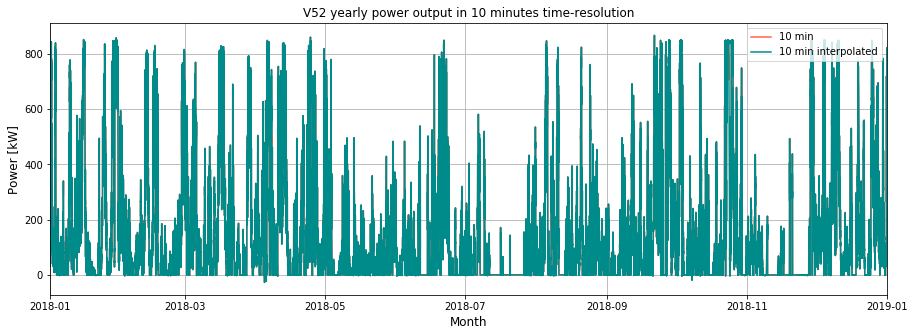

In [6]:
datasetActPow_full10_Interp=datasetActPow_full10.interpolate(method='linear')

plt.figure(figsize=(15,5))
plt.plot(datasetActPow_full10, color='tomato')
plt.plot(datasetActPow_full10_Interp, color='darkcyan')
plt.xlim('2018-01-01 00:00:00', '2019-01-01 00:00:00')
plt.grid(which='both')
plt.legend(['10 min', '10 min interpolated'], loc='upper right')
plt.title('V52 yearly power output in 10 minutes time-resolution')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Power [kW]', fontsize=12)

datasetActPow_full10_Interp.isnull().sum()

### 2.4. Resizing into a 60 minute time resolution

Resample and mean methods are applied to resize this DataFrame into a new one of hourly resolution.

In the figure below both the results of the yearly power output on hourly resolution and 10 minutes resolution are provided. 


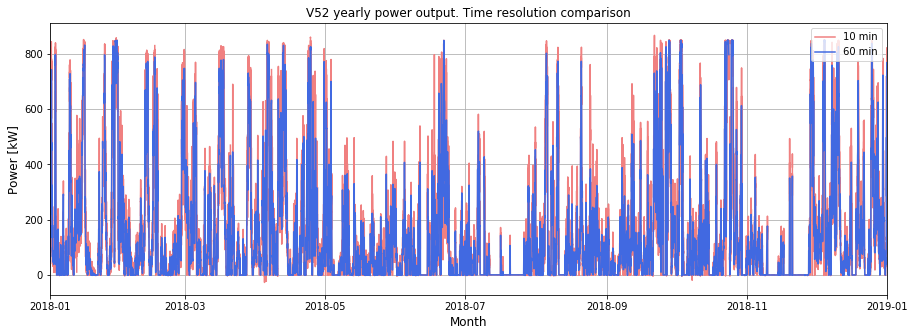

In [7]:
# datasetActPow_full60 = np.mean(datasetActPow_full10.reshape(-1,6), axis = 1)

# datasetActPow_full60.shape
datasetActPow_full60=datasetActPow_full10.resample('H').mean()


datasetActPow_full60.head()


plt.figure(figsize=(15,5))
plt.plot(datasetActPow_full10, color='lightcoral')
plt.plot(datasetActPow_full60, color='royalblue' )
plt.legend(['10 min', '60 min'], loc='upper right')
plt.title('V52 yearly power output. Time resolution comparison')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Power [kW]', fontsize=12)

plt.xlim('2018-01-01 00:00:00', '2019-01-01 00:00:00')
plt.grid(which='both')


# plt.show()




### 2.5. Removal of negative values
As can be stated from the figure above, there are some negative values that have to be removed from the dataset, since they do not have any physical meaning. 


In [8]:
print(datasetActPow_full60.min())

datasetActPow_full60_nonegative=datasetActPow_full60
datasetActPow_full60_nonegative[datasetActPow_full60_nonegative<0]=0
datasetActPow_full60_nonegative.min()


ActPow   -3.976787
dtype: float64


ActPow    0.0
dtype: float64

The minimum value that the power output has it -3.9767 kW, and once it is removed from the DataFrame the minimum value is 0.0

### 2.7. Calculating the difference vector in V52 output power 

The data on which we are currently working are considered time series data. That means that these data also varies with time, meaning that also their properties change (mean, variance and covariace)

In order to reduce the non-stationarity that is on the V52 output power data, we convert the data into a differential dataset between t and t-1. In this case, negative values in the output power difference can be considered. 
This tranformation is done by means of pandas diff method. 

In [9]:
P_v52 = datasetActPow_full60_nonegative
P_v52_diff = P_v52.diff()
P_v52_diff[P_v52_diff.isnull()] = 0

P_v52_diff.head()

,ActPow
Date,
2018-01-01 00:00:00,0.000000
2018-01-01 01:00:00,-38.088700
2018-01-01 02:00:00,7.023100
2018-01-01 03:00:00,44.741233
2018-01-01 04:00:00,-35.613717


In [10]:
P_v52_diff_nval=P_v52_diff.ActPow.values
P_v52_diff_nval.shape

(8760,)

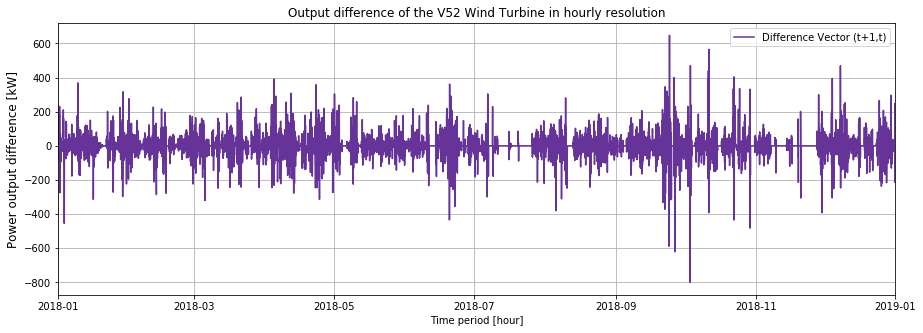

In [11]:
plt.figure(figsize=(15,5))
plt.plot(P_v52_diff, color='rebeccapurple' , label= 'Difference Vector (t+1,t)')
axes = plt.gca()
axes.set_xlim(['2018-01-01','2019-01-01'])
plt.ylabel('Power output difference [kW]', fontsize = 12)
plt.xlabel('Time period [hour]')
plt.grid(which='major')
plt.title('Output difference of the V52 Wind Turbine in hourly resolution')
plt.legend()
plt.show()




## LSTM Model definition

### 3.1. Scaling

Text(0.5, 1.0, 'Output power Difference vector scaling and transformation')

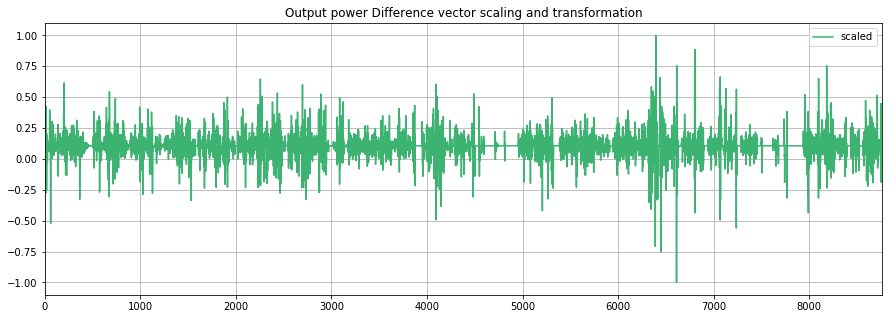

In [12]:

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1)) # Feature = e.g. windspeed. Feature range has to e between 0 and 1 if all positive. or e.g -1 to 1 if you have also negative values
P_v52_train = scaler.fit_transform(P_v52_diff)
P_v52_train.shape


plt.figure(figsize=(15,5))
plt.plot(P_v52_train, color = 'mediumseagreen')
plt.legend(['scaled'], loc='upper right')
plt.xlim(0,8761)
plt.grid()
plt.title('Output power Difference vector scaling and transformation', fontsize = 12)



### 3.2. Rolling Window

In [13]:
# Creating new dataframe with scaled signal
datevector2 = pd.date_range(start='2018-01-01 00:00:00', end='2018-12-31 23:50:00', freq='H')

P_v52_df = pd.DataFrame(index= datevector2)

P_v52_df.index.name = 'Date'
# P_v52_df.tail()
# P_v52_df.shape
# P_v52_train.size

P_v52_df['ActPow'] =  P_v52_train
P_v52_df.head()


,ActPow
Date,
2018-01-01 00:00:00,0.105865
2018-01-01 01:00:00,0.053233
2018-01-01 02:00:00,0.115569
2018-01-01 03:00:00,0.167689
2018-01-01 04:00:00,0.056653


### 3.3. Building the delay matrix and the training matrix


In the following lines, we prepare different models in which we investigate the hyperparameter of the amount of past states to consider for the prediction of the following state of the neural network.

In this investigation, all the other hyperparaeters (e.g. epochs, number of hidden layers and neurons per layer, etc) are kept constant.

MODEL A = 1 day past
MODEL B = 3 days past
MODEL C = 7 days past
MODEL D = 14 days past


In [14]:
import scipy as sp

days_past_A=1
n_window_A=days_past_A*24
toepl_1row_A=np.zeros(n_window_A+1)
toepl_1row_A[0]=P_v52_df.values[0]
idx_A=sp.linalg.toeplitz(P_v52_df,toepl_1row_A)
P_v52_train_delays_A=idx_A

days_past_B=3
n_window_B=days_past_B*24
toepl_1row_B=np.zeros(n_window_B+1)
toepl_1row_B[0]=P_v52_df.values[0]
idx_B=sp.linalg.toeplitz(P_v52_df,toepl_1row_B)
P_v52_train_delays_B=idx_B

days_past_C=7
n_window_C=days_past_C*24
toepl_1row_C=np.zeros(n_window_C+1)
toepl_1row_C[0]=P_v52_df.values[0]
idx_C=sp.linalg.toeplitz(P_v52_df,toepl_1row_C)
P_v52_train_delays_C=idx_C

days_past_D=14
n_window_D=days_past_D*24
toepl_1row_D=np.zeros(n_window_D+1)
toepl_1row_D[0]=P_v52_df.values[0]
idx_D=sp.linalg.toeplitz(P_v52_df,toepl_1row_D)
P_v52_train_delays_D=idx_D



In [15]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.layers import LSTM

Using TensorFlow backend.


### 3.4. Building the LSTM Model 

In [16]:
# for multiple model creation - clear  the previous DAG
K.clear_session() 

### Input reshape for LSTM problem  [samples, timesteps, features]
train_X_A = P_v52_train_delays_A[:,1:]
train_Y_A = P_v52_train_delays_A[:,0]

train_X_B = P_v52_train_delays_B[:,1:]
train_Y_B = P_v52_train_delays_B[:,0]

train_X_C = P_v52_train_delays_C[:,1:]
train_Y_C = P_v52_train_delays_C[:,0]

train_X_D = P_v52_train_delays_D[:,1:]
train_Y_D = P_v52_train_delays_D[:,0]


# Printing shape of training datasets. Last dimension is the number of past values considered. 
# They are consistent

# train_X_exp=np.expand_dims(train_X,axis=0)
print(train_X_A.shape)
print(train_X_B.shape)
print(train_X_C.shape)
print(train_X_D.shape)

# print(train_X_exp.shape)

(8760, 24)
(8760, 72)
(8760, 168)
(8760, 336)


In [17]:
# create model
n_samples_A=train_X_A.shape[0]
n_in_A=train_X_A.shape[1]

n_samples_B=train_X_B.shape[0]
n_in_B=train_X_B.shape[1]

n_samples_C=train_X_C.shape[0]
n_in_C=train_X_C.shape[1]

n_samples_D=train_X_D.shape[0]
n_in_D=train_X_D.shape[1]

n_features=1

train_X_input_A = train_X_A.reshape(train_X_A.shape[0], 1, train_X_A.shape[1])
train_X_input_B = train_X_B.reshape(train_X_B.shape[0], 1, train_X_B.shape[1])
train_X_input_C = train_X_C.reshape(train_X_C.shape[0], 1, train_X_C.shape[1])
train_X_input_D = train_X_D.reshape(train_X_D.shape[0], 1, train_X_D.shape[1])

### 3.5. Models creation

In the following section, four models are created. The hyperparameters that have been chosen are the following ones: 

- 2 Hidden layers (120 and 80 neurons) 
- Activation function: Relu (1st hidden layer)
- Activation function: Linear (2nd hidden layer)
- 250 epochs training
- Loss function: Mean Squared error


In [18]:
model_A = Sequential()
# model.add(LSTM(120, input_shape=(n_samples,n_in,n_features), 
# model.add(LSTM(120, input_shape=(train_X.shape[0],train_X.shape[1],1), 
model_A.add(LSTM(120, input_shape=(train_X_input_A.shape[1],train_X_input_A.shape[2]), 

                kernel_initializer='random_uniform', activation='relu',
                bias_initializer='zeros',
                return_sequences=True)) # important to add it to ensure the following LSTM layers will have the same input shape
# then we add the activation
# model.add(Activation('tanh'))
model_A.add(LSTM(80, activation ='relu'))
# we add Drop-out with a ratio that will put up to 20% of the inputs (to the layer) to zero, feel free to tune it
# model.add(Dropout(0.8))
model_A.add(Dense(1, activation='linear'))

# compile the model
model_A.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])


model_B = Sequential()
model_B.add(LSTM(120, input_shape=(train_X_input_B.shape[1],train_X_input_B.shape[2]), 

                kernel_initializer='random_uniform', activation='relu',
                bias_initializer='zeros',
                return_sequences=True))
model_B.add(LSTM(80, activation ='relu'))
model_B.add(Dense(1, activation='linear'))
model_B.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

model_C = Sequential()
model_C.add(LSTM(120, input_shape=(train_X_input_C.shape[1],train_X_input_C.shape[2]), 

                kernel_initializer='random_uniform', activation='relu',
                bias_initializer='zeros',
                return_sequences=True))
model_C.add(LSTM(80, activation ='relu'))
model_C.add(Dense(1, activation='linear'))
model_C.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

model_D = Sequential()
model_D.add(LSTM(120, input_shape=(train_X_input_D.shape[1],train_X_input_D.shape[2]), 

                kernel_initializer='random_uniform', activation='relu',
                bias_initializer='zeros',
                return_sequences=True))
model_D.add(LSTM(80, activation ='relu'))
model_D.add(Dense(1, activation='linear'))
model_D.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])



### 3.6. Models training 

The estimated training time is 2 seconds/epoch. However, it depends on the computer training the model. 
In this case, the estimated time is: 

\begin{equation*}
    2 · 250 · 4 \approx 2000  s 
\end{equation*}
Furthermore, the number of past values does not affect the training time so much in the model defined in this capstone project. 


In [19]:
## Training model A 

history_A = model_A.fit(train_X_input_A, train_Y_A, epochs=250, verbose=2)

Epoch 1/250
 - 4s - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 2/250
 - 2s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 3/250
 - 2s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 4/250
 - 2s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 5/250
 - 1s - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 6/250
 - 1s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 7/250
 - 2s - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 8/250
 - 1s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 9/250
 - 1s - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 10/250
 - 1s - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 11/250
 - 1s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 12/250
 - 1s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 13/250
 - 2s - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 14/250
 - 2s - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 15/250
 - 1s - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 16/250
 - 1s - loss: 0.0062 - mean_squared_error: 0.0062
E

Epoch 131/250
 - 2s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 132/250
 - 2s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 133/250
 - 2s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 134/250
 - 2s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 135/250
 - 2s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 136/250
 - 2s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 137/250
 - 2s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 138/250
 - 2s - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 139/250
 - 2s - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 140/250
 - 2s - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 141/250
 - 2s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 142/250
 - 2s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 143/250
 - 2s - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 144/250
 - 2s - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 145/250
 - 2s - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 146/250
 - 2s - loss: 0.0022 - mea

In [20]:
# Training model B 

history_B = model_B.fit(train_X_input_B, train_Y_B, epochs=250, verbose=2)


Epoch 1/250
 - 4s - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 2/250
 - 2s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 3/250
 - 2s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 4/250
 - 2s - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 5/250
 - 2s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 6/250
 - 2s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 7/250
 - 2s - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 8/250
 - 2s - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 9/250
 - 2s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 10/250
 - 2s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 11/250
 - 2s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 12/250
 - 2s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 13/250
 - 2s - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 14/250
 - 2s - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 15/250
 - 2s - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 16/250
 - 2s - loss: 0.0047 - mean_squared_error: 0.0047
E

Epoch 129/250
 - 2s - loss: 8.4177e-04 - mean_squared_error: 8.4177e-04
Epoch 130/250
 - 2s - loss: 8.6998e-04 - mean_squared_error: 8.6998e-04
Epoch 131/250
 - 2s - loss: 8.4156e-04 - mean_squared_error: 8.4156e-04
Epoch 132/250
 - 2s - loss: 8.2539e-04 - mean_squared_error: 8.2539e-04
Epoch 133/250
 - 2s - loss: 8.4920e-04 - mean_squared_error: 8.4920e-04
Epoch 134/250
 - 2s - loss: 8.2115e-04 - mean_squared_error: 8.2115e-04
Epoch 135/250
 - 2s - loss: 7.9593e-04 - mean_squared_error: 7.9593e-04
Epoch 136/250
 - 2s - loss: 8.1778e-04 - mean_squared_error: 8.1778e-04
Epoch 137/250
 - 2s - loss: 8.3483e-04 - mean_squared_error: 8.3483e-04
Epoch 138/250
 - 2s - loss: 8.5012e-04 - mean_squared_error: 8.5012e-04
Epoch 139/250
 - 2s - loss: 7.7590e-04 - mean_squared_error: 7.7590e-04
Epoch 140/250
 - 2s - loss: 7.7175e-04 - mean_squared_error: 7.7175e-04
Epoch 141/250
 - 2s - loss: 7.8504e-04 - mean_squared_error: 7.8504e-04
Epoch 142/250
 - 2s - loss: 8.1667e-04 - mean_squared_error: 8.1

Epoch 243/250
 - 2s - loss: 4.6948e-04 - mean_squared_error: 4.6948e-04
Epoch 244/250
 - 2s - loss: 4.9998e-04 - mean_squared_error: 4.9998e-04
Epoch 245/250
 - 2s - loss: 5.1163e-04 - mean_squared_error: 5.1163e-04
Epoch 246/250
 - 2s - loss: 4.5015e-04 - mean_squared_error: 4.5015e-04
Epoch 247/250
 - 2s - loss: 4.4663e-04 - mean_squared_error: 4.4663e-04
Epoch 248/250
 - 2s - loss: 4.6513e-04 - mean_squared_error: 4.6513e-04
Epoch 249/250
 - 2s - loss: 4.7331e-04 - mean_squared_error: 4.7331e-04
Epoch 250/250
 - 2s - loss: 4.7003e-04 - mean_squared_error: 4.7003e-04


In [21]:
# Training model C 

history_C = model_C.fit(train_X_input_C, train_Y_C, epochs=250, verbose=2)

Epoch 1/250
 - 4s - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 2/250
 - 2s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 3/250
 - 2s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 4/250
 - 2s - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 5/250
 - 2s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 6/250
 - 2s - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 7/250
 - 2s - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 8/250
 - 2s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 9/250
 - 2s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 10/250
 - 2s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 11/250
 - 2s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 12/250
 - 2s - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 13/250
 - 2s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 14/250
 - 2s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 15/250
 - 2s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 16/250
 - 2s - loss: 0.0043 - mean_squared_error: 0.0043
E

Epoch 123/250
 - 2s - loss: 3.9394e-04 - mean_squared_error: 3.9394e-04
Epoch 124/250
 - 2s - loss: 3.5567e-04 - mean_squared_error: 3.5567e-04
Epoch 125/250
 - 2s - loss: 3.2152e-04 - mean_squared_error: 3.2152e-04
Epoch 126/250
 - 2s - loss: 3.1341e-04 - mean_squared_error: 3.1341e-04
Epoch 127/250
 - 2s - loss: 3.1200e-04 - mean_squared_error: 3.1200e-04
Epoch 128/250
 - 2s - loss: 3.4284e-04 - mean_squared_error: 3.4284e-04
Epoch 129/250
 - 2s - loss: 3.6758e-04 - mean_squared_error: 3.6758e-04
Epoch 130/250
 - 2s - loss: 3.9152e-04 - mean_squared_error: 3.9152e-04
Epoch 131/250
 - 2s - loss: 3.3975e-04 - mean_squared_error: 3.3975e-04
Epoch 132/250
 - 2s - loss: 3.2228e-04 - mean_squared_error: 3.2228e-04
Epoch 133/250
 - 2s - loss: 2.9004e-04 - mean_squared_error: 2.9004e-04
Epoch 134/250
 - 2s - loss: 3.0872e-04 - mean_squared_error: 3.0872e-04
Epoch 135/250
 - 2s - loss: 3.2986e-04 - mean_squared_error: 3.2986e-04
Epoch 136/250
 - 2s - loss: 3.3952e-04 - mean_squared_error: 3.3

Epoch 237/250
 - 2s - loss: 1.7126e-04 - mean_squared_error: 1.7126e-04
Epoch 238/250
 - 2s - loss: 1.6809e-04 - mean_squared_error: 1.6809e-04
Epoch 239/250
 - 2s - loss: 1.4381e-04 - mean_squared_error: 1.4381e-04
Epoch 240/250
 - 2s - loss: 1.5135e-04 - mean_squared_error: 1.5135e-04
Epoch 241/250
 - 2s - loss: 1.6985e-04 - mean_squared_error: 1.6985e-04
Epoch 242/250
 - 2s - loss: 1.3391e-04 - mean_squared_error: 1.3391e-04
Epoch 243/250
 - 2s - loss: 1.4814e-04 - mean_squared_error: 1.4814e-04
Epoch 244/250
 - 2s - loss: 1.4517e-04 - mean_squared_error: 1.4517e-04
Epoch 245/250
 - 2s - loss: 1.5619e-04 - mean_squared_error: 1.5619e-04
Epoch 246/250
 - 2s - loss: 1.8320e-04 - mean_squared_error: 1.8320e-04
Epoch 247/250
 - 2s - loss: 1.4499e-04 - mean_squared_error: 1.4499e-04
Epoch 248/250
 - 2s - loss: 1.6831e-04 - mean_squared_error: 1.6831e-04
Epoch 249/250
 - 2s - loss: 1.4117e-04 - mean_squared_error: 1.4117e-04
Epoch 250/250
 - 2s - loss: 1.5567e-04 - mean_squared_error: 1.5

In [22]:
# Training model D 

history_D = model_D.fit(train_X_input_D, train_Y_D, epochs=250, verbose=2)

Epoch 1/250
 - 5s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 2/250
 - 2s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 3/250
 - 2s - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 4/250
 - 2s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 5/250
 - 2s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 6/250
 - 2s - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 7/250
 - 2s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 8/250
 - 2s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 9/250
 - 2s - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 10/250
 - 2s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 11/250
 - 2s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 12/250
 - 2s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 13/250
 - 2s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 14/250
 - 2s - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 15/250
 - 2s - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 16/250
 - 2s - loss: 0.0050 - mean_squared_error: 0.0050
E

Epoch 123/250
 - 2s - loss: 2.2812e-04 - mean_squared_error: 2.2812e-04
Epoch 124/250
 - 2s - loss: 2.5034e-04 - mean_squared_error: 2.5034e-04
Epoch 125/250
 - 2s - loss: 2.3999e-04 - mean_squared_error: 2.3999e-04
Epoch 126/250
 - 3s - loss: 1.9850e-04 - mean_squared_error: 1.9850e-04
Epoch 127/250
 - 2s - loss: 2.1227e-04 - mean_squared_error: 2.1227e-04
Epoch 128/250
 - 2s - loss: 2.2739e-04 - mean_squared_error: 2.2739e-04
Epoch 129/250
 - 2s - loss: 2.2490e-04 - mean_squared_error: 2.2490e-04
Epoch 130/250
 - 2s - loss: 2.3169e-04 - mean_squared_error: 2.3169e-04
Epoch 131/250
 - 2s - loss: 2.2482e-04 - mean_squared_error: 2.2482e-04
Epoch 132/250
 - 2s - loss: 2.1035e-04 - mean_squared_error: 2.1035e-04
Epoch 133/250
 - 2s - loss: 2.2357e-04 - mean_squared_error: 2.2357e-04
Epoch 134/250
 - 2s - loss: 2.1741e-04 - mean_squared_error: 2.1741e-04
Epoch 135/250
 - 3s - loss: 2.2197e-04 - mean_squared_error: 2.2197e-04
Epoch 136/250
 - 2s - loss: 1.9081e-04 - mean_squared_error: 1.9

Epoch 237/250
 - 2s - loss: 1.0906e-04 - mean_squared_error: 1.0906e-04
Epoch 238/250
 - 2s - loss: 9.4574e-05 - mean_squared_error: 9.4574e-05
Epoch 239/250
 - 2s - loss: 9.1733e-05 - mean_squared_error: 9.1733e-05
Epoch 240/250
 - 2s - loss: 8.0584e-05 - mean_squared_error: 8.0584e-05
Epoch 241/250
 - 2s - loss: 9.1721e-05 - mean_squared_error: 9.1721e-05
Epoch 242/250
 - 2s - loss: 9.0102e-05 - mean_squared_error: 9.0102e-05
Epoch 243/250
 - 2s - loss: 9.0867e-05 - mean_squared_error: 9.0867e-05
Epoch 244/250
 - 2s - loss: 9.0617e-05 - mean_squared_error: 9.0617e-05
Epoch 245/250
 - 2s - loss: 9.5366e-05 - mean_squared_error: 9.5366e-05
Epoch 246/250
 - 2s - loss: 1.0384e-04 - mean_squared_error: 1.0384e-04
Epoch 247/250
 - 2s - loss: 1.2398e-04 - mean_squared_error: 1.2398e-04
Epoch 248/250
 - 2s - loss: 9.9694e-05 - mean_squared_error: 9.9694e-05
Epoch 249/250
 - 2s - loss: 8.8005e-05 - mean_squared_error: 8.8005e-05
Epoch 250/250
 - 2s - loss: 9.6464e-05 - mean_squared_error: 9.6

### 3.7. Training accuracy 

Below we can see that the loss function is lower for models that account for more past output states (i.e. Models C and D)

They reach a better accuracy and also faster (i.e. after 150 epochs the models do not change much in accuracy)


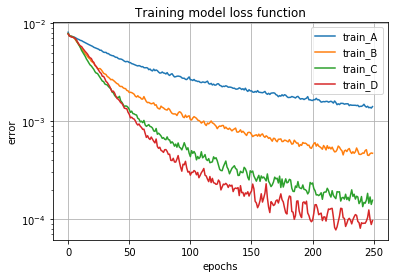

In [23]:
### plot history
plt.plot(history_A.history['loss'], label='train_A')
plt.plot(history_B.history['loss'], label='train_B')
plt.plot(history_C.history['loss'], label='train_C')
plt.plot(history_D.history['loss'], label='train_D')
# plt.plot(history.history['val_loss'], label='test')
plt.grid(which='major')
plt.title('Training model loss function')
plt.xlabel('epochs')
plt.ylabel('error')
plt.yscale('log')
plt.legend()
plt.show()



## 4 Market Analysis based on Nordpool DAM

In this section, the power forecast is being assessed by means of its economic value, considering the available market data from 2018 of the Nordpool DAM. The zone where the V52 turbine is located and, whereas, can bid to the DAM is DK2 zone (Riso DTU Campus). In the following figure, the Nordpool market zones are shown, covering the following countries: Denmark (divided into Eastern Denmark and Western Denmark), Finland, Estona, Lithuania, Latvia, Norway (five bidding zones) and Sweden (divided into four bidding zones). 

![Source: Nordpool Electricity Market](https://www.nordpoolgroup.com/globalassets/images/graphics/bidding_areas-002.png?width=200&quality=90)

### 4.1. Data visualization
In the figure below, the 2018 hourly prices of DK2 bidding area can be observed. Furthermore, the maximum DAM price is obtained. 

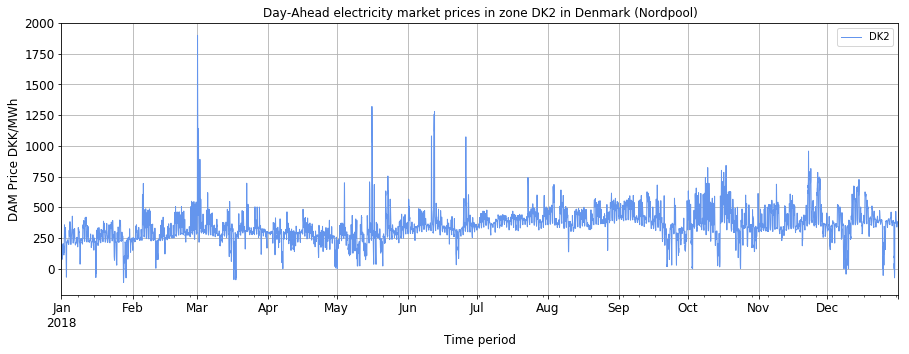

The maximum DAM price was: [1898.9] DKK/MWh on ['2018-03-01T08:00:00.000000000']


In [24]:
file = 'elspot-prices_2018_hourly_dkk_new.xlsx' 
 
##READ THE INPUTS FROM EXCEL## 
 
## Parsing input file 

dataset_price = pd.read_excel(file, skiprows=2, header = 0, index_col = 0, decimal=',', thousands=None)

datevector = pd.date_range(start = '2018-01-01', end='2019-01-01', freq='1H') #we create an index vector of all the time

dataset_price.index = datevector

dataset_price_DK2 = dataset_price.loc[:,['DK2']]

# we just need the data from DK2
ax = dataset_price_DK2.plot(figsize = (15,5), linewidth = 1, fontsize = 12, label ='DK2 price', color='cornflowerblue')

plt.title('Day-Ahead electricity market prices in zone DK2 in Denmark (Nordpool)')
plt.ylabel('DAM Price DKK/MWh', fontsize=12)
plt.xlabel('Time period', fontsize=12)
plt.grid(which='major')
plt.xlim('2018-01-01 00:00:00', '2018-12-31 23:00:00')
plt.legend()
plt.show()

#### find the maximum price of 2018

max_DK2_DAM_price = dataset_price_DK2.max()
max_DK2_DAM_day = dataset_price_DK2.idxmax()

print('The maximum DAM price was:', max_DK2_DAM_price.values, 'DKK/MWh on', max_DK2_DAM_day.values)

### 4.2 Indentification of the best day for the prediction

In order to find the best day to test our prediction, the revenues obtained on each day considering the hourly electricity price and the hourly power calculated precendently, has been considered. 

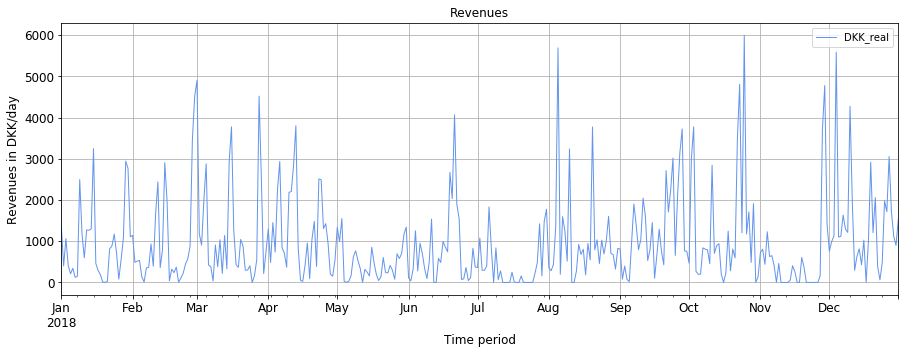

The maximum revenue per day in the year was: [5998.01857952] DKK on  ['2018-10-25T00:00:00.000000000']


In [25]:
dataset_price_DK2 = dataset_price_DK2.rename_axis("Date")

#Create dataframe with hourly electricity price and production
MergedData = pd.merge(dataset_price_DK2,P_v52, 
                      how = 'inner', on = 'Date')

#Create a revenue dataframe in which the hourly reveues are reported
Revenues = MergedData.DK2 * MergedData.ActPow/1000
Revenues = Revenues.to_frame(name = 'DKK_real')
Revenues.index = pd.to_datetime(Revenues.index)

#Resample the revenues dataframe to have the revenues per day and identify the best day to test the prediction
Revenues_per_day = Revenues.resample('1D').sum()

#Plot the revenues per day
ax = Revenues_per_day.plot(figsize = (15,5), linewidth = 1, fontsize = 12, label ='DK2 price', color='cornflowerblue')

plt.title('Revenues')
plt.ylabel('Revenues in DKK/day', fontsize=12)
plt.xlabel('Time period', fontsize=12)
plt.grid(which='major')
plt.xlim('2018-01-01', '2018-12-31')
plt.legend()
plt.show()

#Determine the maximum revenues and the corresponding day: 
Max_revenue_per_day = Revenues_per_day.max().values
Day_max_revenue = Revenues_per_day.idxmax().values

print('The maximum revenue per day in the year was:', Max_revenue_per_day, 'DKK on ', Day_max_revenue)

Based on the analysis, the day allowing the higher revenues is the 25th of October 2018. For this reason the comparison between prediction and real data will be made on this date.

In [26]:
#Start_ind corresponds to the row associated to the first hour of the selected day
start_ind=P_v52.index.get_loc('2018-10-25 00:00')
#start_ind=500

end_ind=P_v52.index.get_loc('2018-10-25 23:00')
#end_ind=start_ind+23


print(start_ind)
print(end_ind)

7128
7151


## 5. Power forecast 

In this section the V52 power output is forecasted. However, it has to be remarked that this prediction is done in the so called open-loop configuration. That means that the real power data (i.e. those used during the training process) are assumed as available also for the prediciton. Hence, our networks use REAL past power output values to estimate the next input.

_- I.e. To estimate Yt we use the past outputs states {Y(t-1)...Y(t-n)} taken from the training dataset, and NOT the {Y(t-1)...Y(t-n)} predicted from the neural networks_

### 5.1 Open loop prediction

In [27]:
## OPEN LOOP PREDICTION
# OPEN LOOP: We assume that the REAL power data (i.e. those used during the training process) are available also for the prediction
# THis means that our networks use REAL pas outputs to estimate the next input. I.e. To estimate Yt we use the past outputs states
# {Y(t-1)...Y(t-n)} taken from the training dataset, and NOT the {Y(t-1)...Y(t-n)} predicted from the neural networks

test_X_A=train_X_input_A[start_ind+1:end_ind+1,:,:]

test_X_B=train_X_input_B[start_ind+1:end_ind+1,:,:]

test_X_C=train_X_input_C[start_ind+1:end_ind+1,:,:]

test_X_D=train_X_input_D[start_ind+1:end_ind+1,:,:]

Y_predict_A=model_A.predict(test_X_A)
Y_predict_B=model_B.predict(test_X_B)
Y_predict_C=model_C.predict(test_X_C)
Y_predict_D=model_D.predict(test_X_D)

### 5.2. Upscaling

In [28]:
Y_predict_upscaled_A=scaler.inverse_transform(Y_predict_A)
Y_predict_upscaled_B=scaler.inverse_transform(Y_predict_B)
Y_predict_upscaled_C=scaler.inverse_transform(Y_predict_C)
Y_predict_upscaled_D=scaler.inverse_transform(Y_predict_D)

### 5.3. Power signals forecast 

As can be seen in the figure below, clearly model D outperforms other models. However, once again it has to be remarked that it is an **open-loop** prediction. 

In an eventual closed-loop prediction, the performance of all the models is expected to decrease.


[array([483.2015]), array([797.86397559]), array([838.06698996]), array([859.65667731]), array([878.68451506]), array([868.93440634]), array([886.88855559]), array([889.54459626]), array([886.94511968]), array([869.41577512]), array([853.7522791]), array([862.77756578]), array([875.30337793]), array([881.7627452]), array([897.04435092]), array([865.52694065]), array([829.12816745]), array([874.46940357]), array([913.84372455]), array([852.25026065]), array([699.29902774]), array([649.69968921]), array([619.8601926]), array([479.5177396])]


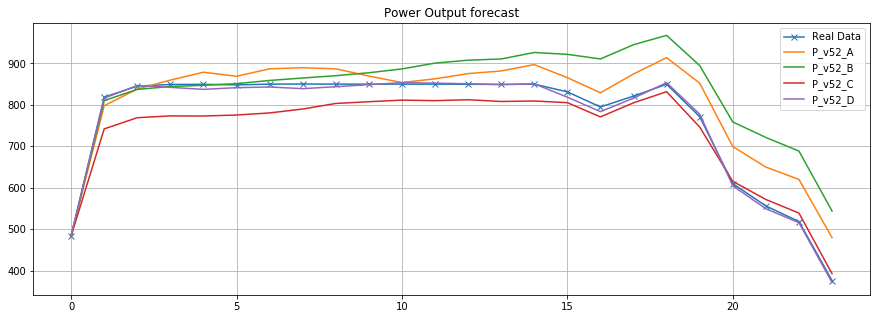

In [38]:
P_v52_predicted_A=[]
P_v52_predicted_B=[]
P_v52_predicted_C=[]
P_v52_predicted_D=[]

# P_v52_predicted=pd.DataFrame()

#print(P_v52.shape)
P_v52_predicted_A.append(P_v52.values[start_ind])
P_v52_predicted_B.append(P_v52.values[start_ind])
P_v52_predicted_C.append(P_v52.values[start_ind])
P_v52_predicted_D.append(P_v52.values[start_ind])

# len(Y_predict_upscaled)

for i in range(1,len(Y_predict_upscaled_A)+1) :
    P_v52_predicted_A.append(P_v52_predicted_A[i-1] + Y_predict_upscaled_A[i-1])
    P_v52_predicted_B.append(P_v52_predicted_B[i-1] + Y_predict_upscaled_B[i-1])
    P_v52_predicted_C.append(P_v52_predicted_C[i-1] + Y_predict_upscaled_C[i-1])
    P_v52_predicted_D.append(P_v52_predicted_D[i-1] + Y_predict_upscaled_D[i-1])

plt.figure(figsize=(15,5))
plt.plot(P_v52.values[start_ind:end_ind+1], label='Real Data', marker='x')
plt.plot(P_v52_predicted_A, label='P_v52_A')
plt.plot(P_v52_predicted_B, label='P_v52_B')
plt.plot(P_v52_predicted_C, label='P_v52_C')
plt.plot(P_v52_predicted_D, label='P_v52_D')
plt.grid()
plt.title('Power Output forecast')
plt.legend()
plt.show()

## 6. Market analysis: Comparison forecast and real data. 

### 6.1 Revenues calculation
To test the forecast quality, the predicted revenues and the real ones are compared for the hours of the selected day.

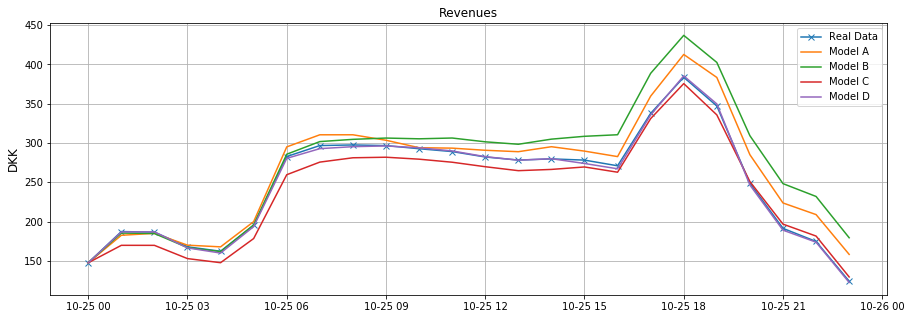

In [60]:
#Real revenues
Revenues_best_day_REAL = Revenues[(Revenues.index > '2018-10-24 23:59') & (Revenues.index < '2018-10-26 00:00')]

#Electricity cost for the selected day
dataset_price_best_day = dataset_price_DK2[(dataset_price_DK2.index > '2018-10-24 23:59')
                                           & (dataset_price_DK2.index < '2018-10-26 00:00')]

#time vector for the predicted values
time = pd.date_range(start = '2018-10-25 00:00', end='2018-10-25 23:00', freq='1H')

#Power prediction model A
power_prediction_A = pd.DataFrame(P_v52_predicted_A)
#Revenues prediction model A
Revenues_A = power_prediction_A.values*dataset_price_best_day.values/1000
Revenues_best_day_prediction_A = pd.DataFrame(Revenues_A, index = [time], columns = ['DKK_model_A'])

#Power prediction model B
power_prediction_B = pd.DataFrame(P_v52_predicted_B)
#Revenues prediction model B
Revenues_B = power_prediction_B.values*dataset_price_best_day.values/1000
Revenues_best_day_prediction_B = pd.DataFrame(Revenues_B, index = [time], columns = ['DKK_model_B'])


#Power prediction model C
power_prediction_C = pd.DataFrame(P_v52_predicted_C)
#Revenues prediction model C
Revenues_C = power_prediction_C.values*dataset_price_best_day.values/1000
Revenues_best_day_prediction_C = pd.DataFrame(Revenues_C, index = [time], columns = ['DKK_model_C'])

#Power prediction model D
power_prediction_D = pd.DataFrame(P_v52_predicted_D)
#Revenues prediction model D
Revenues_D = power_prediction_D.values*dataset_price_best_day.values/1000
Revenues_best_day_prediction_D = pd.DataFrame(Revenues_D, index = [time], columns = ['DKK_model_D'])

plt.figure(figsize=(15,5))
plt.plot(Revenues_best_day_REAL, label='Real Data', marker='x')
plt.plot(Revenues_best_day_prediction_A, label='Model A')
plt.plot(Revenues_best_day_prediction_B, label='Model B')
plt.plot(Revenues_best_day_prediction_C, label='Model C')
plt.plot(Revenues_best_day_prediction_D, label='Model D')
plt.ylabel('DKK', fontsize=12)
plt.grid()
plt.title('Revenues')
plt.legend()
plt.show()

### 6.2 Error evaluation
To quantify the goodness of the forecast the mismatch between the real revenues and the predicted one is evaluated

Mean squared error model A = 19.050076832137343 DKK
Mean squared error model B = 33.12132736444863 DKK
Mean squared error model C = 13.137948663328727 DKK
Mean squared error model D = 2.022492891442215 DKK


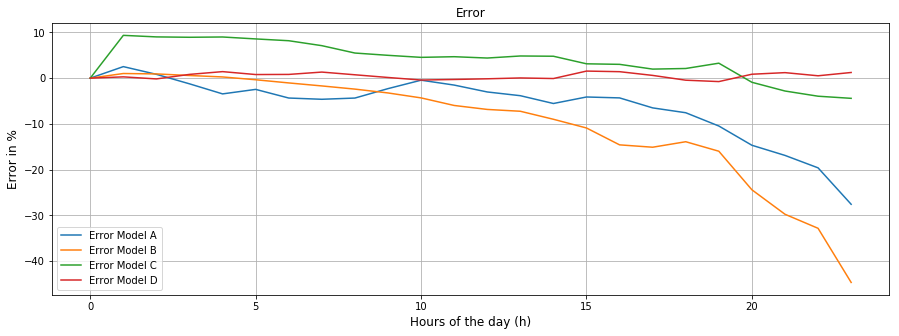

In [61]:
Error_A = ((Revenues_best_day_REAL.values-Revenues_best_day_prediction_A.values)/Revenues_best_day_REAL.values*100)
Error_B = ((Revenues_best_day_REAL.values-Revenues_best_day_prediction_B.values)/Revenues_best_day_REAL.values*100)
Error_C = ((Revenues_best_day_REAL.values-Revenues_best_day_prediction_C.values)/Revenues_best_day_REAL.values*100)
Error_D = ((Revenues_best_day_REAL.values-Revenues_best_day_prediction_D.values)/Revenues_best_day_REAL.values*100)

RMSE_A = np.sqrt(np.sum((Revenues_best_day_REAL.values-Revenues_best_day_prediction_A.values)**2/len(Error_A)))
RMSE_B = np.sqrt(np.sum((Revenues_best_day_REAL.values-Revenues_best_day_prediction_B.values)**2/len(Error_B)))
RMSE_C = np.sqrt(np.sum((Revenues_best_day_REAL.values-Revenues_best_day_prediction_C.values)**2/len(Error_C)))
RMSE_D = np.sqrt(np.sum((Revenues_best_day_REAL.values-Revenues_best_day_prediction_D.values)**2/len(Error_D)))


print('Mean squared error model A =', RMSE_A, 'DKK')
print('Mean squared error model B =', RMSE_B, 'DKK')
print('Mean squared error model C =', RMSE_C, 'DKK')
print('Mean squared error model D =', RMSE_D, 'DKK')

plt.figure(figsize=(15,5))
plt.plot(Error_A, label='Error Model A')
plt.plot(Error_B, label='Error Model B')
plt.plot(Error_C, label='Error Model C')
plt.plot(Error_D, label='Error Model D')
plt.ylabel('Error in %', fontsize=12)
plt.xlabel('Hours of the day (h)', fontsize=12)
plt.grid()
plt.title('Error')
plt.legend()
plt.show()



   ## 7. Conclusion

The four models are able to predict the power production in the selected day, and thus the revenue stream, with a good level of accuracy. The model using 14 days in the past to predict the production shows the best preformances with a mean squared error of 2 DKK